In [4]:
import time
import numpy as np
import pandas as pd
from scipy import stats
pd.options.display.float_format = '{:,.3f}'.format

# %matplotlib notebook
import seaborn as sns
sns.set(style="ticks", color_codes=True)
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA, NMF
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

class Data:
    #storage class for data
    def __init__(self, filename, subset_count=None):
        x = pd.read_csv(filename, index_col='id')
        if subset_count is not None: # Nice to use for testing
            permut = np.random.permutation(x.shape[0])[:subset_count]
            x = x.iloc[permut, :]
        
        self.df_y = x['loss']
        y = x['loss'].values
        del x['loss']

        convertedX = pd.get_dummies(x, drop_first=True)
        X = convertedX.values
        self.X = X
        self.y = y
        
        self.df_X = convertedX
        self.df_X_test = None
    
    def get_split(self, test_size=0.20, pca_components=None, nmf_components=None):
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y,
                                                            test_size=test_size)
        if pca_components is not None:
            pca = PCA(n_components=pca_components)
            pca.fit(X_train)
            X_train = pca.transform(X_train)
            X_test = pca.transform(X_test)
        elif nmf_components:
            nmf = NMF(n_components=nmf_components)
            X_train = nmf.fit_transform(X_train)
            X_test = nmf.transform(X_test)
        return  X_train, X_test, y_train, y_test
    
    def remove_columns(self, columns):
        columns = tuple(columns)
        for col in self.df_X.columns:
            if col.startswith(columns):
                del self.df_X[col]
        self.X = self.df_X.values
    
    def read_test_data(self, filename):
        X_test = pd.read_csv(filename, index_col='id')
        X_test = pd.get_dummies(X_test, drop_first=True)

        additional_columns = set(X_test.columns) - set(self.df_X.columns)
        X_test = X_test.drop(columns=additional_columns)

        missing_columns = set(self.df_X.columns) - set(X_test.columns)
        for col in missing_columns:
            X_test[col] = 0
            
        self.df_X_test = X_test
        return X_test.values
    
def evaluate(name, estimator, X_train, X_test, y_train, y_test):
    t_0 = time.time()
    print(f'{name}:')
    estimator.fit(X_train, y_train)
    
    t_1 = time.time()
    print(f'\tTime elapsed for model construction {t_1 - t_0:.3f} sec')
    y_test_predict = estimator.predict(X_test)
    error_test = mean_absolute_error(y_test, y_test_predict)
    error_train = mean_absolute_error(y_train, estimator.predict(X_train))
    print(f'\tTime elapsed for prediction {time.time() - t_1:.3f} sec')
    print(f'\tTest error: {error_test:.3f}')
    print(f'\tTrain error: {error_train:.3f}')
    return error_test

In [ ]:
# First overall test
data = Data("train.csv")
data.remove_columns(['cont9', 'cont12', 'cat2', 'cat3', 'cat4',
                     'cat5', 'cat6', 'cat7', 'cat8', 'cat86'])
X_train, X_test, y_train, y_test = data.get_split()

ESTIMATORS = {
    # Linear
    "LinearRegression": LinearRegression(n_jobs=-1),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    # Non-linear
    "BaggingRegressor": BaggingRegressor(n_jobs=-1),
    "ExtraTreesRegressor": ExtraTreesRegressor(n_jobs=-1),
    "RandomForestRegressor": RandomForestRegressor(n_jobs=-1),
    "GradientBoostingRegressor": GradientBoostingRegressor(loss='huber'),
    "MLP":  MLPRegressor(hidden_layer_sizes=(150,)),
    "KNeighborsRegressor": KNeighborsRegressor(n_jobs=-1),
    "SVR": SVR(),
}

for name, estimator in ESTIMATORS.items():
    evaluate(name, estimator, X_train, X_test, y_train, y_test)

LinearRegression:
	Time elapsed for model construction 23.044 sec
	Time elapsed for prediction 0.478 sec
	Test error: 8798305800.629
	Train error: 1480.444
Ridge:
	Time elapsed for model construction 5.009 sec
	Time elapsed for prediction 0.391 sec
	Test error: 1477.830
	Train error: 1481.719
Lasso:
	Time elapsed for model construction 55.786 sec
	Time elapsed for prediction 0.389 sec
	Test error: 1481.435
	Train error: 1493.583
ElasticNet:
	Time elapsed for model construction 6.423 sec
	Time elapsed for prediction 0.389 sec
	Test error: 1745.976
	Train error: 1764.948
BaggingRegressor:
	Time elapsed for model construction 136.550 sec
	Time elapsed for prediction 34.328 sec
	Test error: 1519.984
	Train error: 605.857
ExtraTreesRegressor:
	Time elapsed for model construction 279.494 sec
	Time elapsed for prediction 1.537 sec
	Test error: 1535.685
	Train error: 0.072
RandomForestRegressor:
	Time elapsed for model construction 139.742 sec
	Time elapsed for prediction 1.370 sec
	Test error

C:\Users\Notandi\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


	Time elapsed for model construction 2397.275 sec
	Time elapsed for prediction 2.283 sec
	Test error: 1410.916
	Train error: 1392.052
KNeighborsRegressor:
	Time elapsed for model construction 119.529 sec
	Time elapsed for prediction 17134.402 sec
	Test error: 1672.010
	Train error: 1364.940
SVR:


In [ ]:
ESTIMATORS = {
    # Linear
    "LinearRegression": LinearRegression(n_jobs=-1),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    # Non-linear
    "BaggingRegressor": BaggingRegressor(n_jobs=-1),
    "ExtraTreesRegressor": ExtraTreesRegressor(n_jobs=-1),
    "RandomForestRegressor": RandomForestRegressor(n_jobs=-1),
    "GradientBoostingRegressor": GradientBoostingRegressor(loss='huber'),
    "MLP":  MLPRegressor(hidden_layer_sizes=(150,)),
}

# Test PCA and NMF
data = Data("train.csv")

X_train, X_test, y_train, y_test = data.get_split(pca_components=120)
print(f'PCA with 120 components')
for name, estimator in ESTIMATORS.items():
    evaluate(name, estimator, X_train, X_test, y_train, y_test)
    
X_train, X_test, y_train, y_test = data.get_split(nmf_components=90)
print(f'NMF with 90 components')
for name, estimator in ESTIMATORS.items():
    evaluate(name, estimator, X_train, X_test, y_train, y_test)

PCA with 120 components
LinearRegression:
	Time elapsed for model construction 1.222 sec
	Time elapsed for prediction 0.052 sec
	Test error: 1336.491
	Train error: 1326.450
Ridge:
	Time elapsed for model construction 0.375 sec
	Time elapsed for prediction 0.047 sec
	Test error: 1336.488
	Train error: 1326.447
Lasso:
	Time elapsed for model construction 0.735 sec
	Time elapsed for prediction 0.050 sec
	Test error: 1335.520
	Train error: 1325.040
ElasticNet:
	Time elapsed for model construction 0.688 sec
	Time elapsed for prediction 0.059 sec
	Test error: 1503.928
	Train error: 1487.781
BaggingRegressor:
	Time elapsed for model construction 159.103 sec
	Time elapsed for prediction 7.503 sec
	Test error: 1385.234
	Train error: 551.043
ExtraTreesRegressor:
	Time elapsed for model construction 37.692 sec
	Time elapsed for prediction 0.782 sec
	Test error: 1379.454
	Train error: 0.001
RandomForestRegressor:
	Time elapsed for model construction 151.161 sec
	Time elapsed for prediction 0.754 s

C:\Users\Notandi\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


	Time elapsed for model construction 327.754 sec
	Time elapsed for prediction 1.168 sec
	Test error: 1224.814
	Train error: 1195.139

NMF with 90 components
LinearRegression:
	Time elapsed for model construction 0.858 sec
	Time elapsed for prediction 0.047 sec
	Test error: 1372.249
	Train error: 1369.867
Ridge:
	Time elapsed for model construction 0.288 sec
	Time elapsed for prediction 0.031 sec
	Test error: 1367.990
	Train error: 1366.349
Lasso:
	Time elapsed for model construction 1.047 sec
	Time elapsed for prediction 0.047 sec
	Test error: 1380.740
	Train error: 1380.795
ElasticNet:
	Time elapsed for model construction 0.509 sec
	Time elapsed for prediction 0.047 sec
	Test error: 1969.046
	Train error: 1961.323
BaggingRegressor:
	Time elapsed for model construction 63.872 sec
	Time elapsed for prediction 6.347 sec
	Test error: 1350.245
	Train error: 536.754
ExtraTreesRegressor:
	Time elapsed for model construction 28.637 sec
	Time elapsed for prediction 0.648 sec
	Test error: 1359.

C:\Users\Notandi\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


	Time elapsed for model construction 1372.075 sec
	Time elapsed for prediction 6.929 sec
	Test error: 1363.668
	Train error: 1361.900


In [ ]:
data = Data("train.csv")
X_train, X_test, y_train, y_test = data.get_split()
for n_estimators in np.arange(200, 601, 50):
    estimator = GradientBoostingRegressor(loss='huber', alpha=0.5,
                                n_estimators=n_estimators, max_depth=6,
                                learning_rate=0.1, min_samples_leaf=10,
                                min_samples_split=10)
    evaluate(f'GBR n_estimators={n_estimators}',
             estimator, X_train, X_test, y_train, y_test)

GBR n_estimators=200:
	Time elapsed for model construction 9316.946 sec
	Time elapsed for prediction 4.889 sec
	Test error: 1163.757
	Train error: 1086.791
GBR n_estimators=250:
	Time elapsed for model construction 5754.714 sec
	Time elapsed for prediction 4.712 sec
	Test error: 1162.030
	Train error: 1076.098
GBR n_estimators=300:
	Time elapsed for model construction 6771.478 sec
	Time elapsed for prediction 5.666 sec
	Test error: 1160.265
	Train error: 1066.413
GBR n_estimators=350:
	Time elapsed for model construction 23563.061 sec
	Time elapsed for prediction 7.427 sec
	Test error: 1159.374
	Train error: 1057.450
GBR n_estimators=400:
	Time elapsed for model construction 8711.057 sec
	Time elapsed for prediction 7.002 sec
	Test error: 1158.555
	Train error: 1052.084
GBR n_estimators=450:
	Time elapsed for model construction 9692.810 sec
	Time elapsed for prediction 7.645 sec
	Test error: 1158.072
	Train error: 1046.006
GBR n_estimators=500:
	Time elapsed for model construction 1079

In [17]:
# Reading in the final test data
data = Data("train.csv")
X_train, y_train = data.df_X, data.df_y
X_test = data.read_test_data("test.csv")
X_test = data.df_X_test

estimator = GradientBoostingRegressor(loss='huber', alpha=0.5,
                                n_estimators=600, max_depth=6,
                                learning_rate=0.1, min_samples_leaf=10,
                                min_samples_split=10)

t_0 = time.time()
estimator.fit(X_train, y_train)

t_1 = time.time()
print(f'Time elapsed for model construction {t_1 - t_0:.3f} sec')

y_test_predict = estimator.predict(X_test)

X_test['loss'] = y_test_predict
X_test['loss'].to_csv("GBR-submission.csv", header=True)

Time elapsed for model construction 10289.486 sec


In [21]:
data = Data("train.csv")
X_train, y_train = data.df_X, data.df_y
X_test = data.read_test_data("test.csv")
X_test = data.df_X_test

nmf = NMF(n_components=90)
X_train_trans = nmf.fit_transform(X_train)
X_test_trans = nmf.transform(X_test)

gbr = GradientBoostingRegressor(loss='huber', alpha=0.5,
                                n_estimators=600, max_depth=6,
                                learning_rate=0.1, min_samples_leaf=10,
                                min_samples_split=10)

t_0 = time.time()
gbr.fit(X_train_trans, y_train)

t_1 = time.time()
print(f'Time elapsed for model construction {t_1 - t_0:.3f} sec')

y_test_predict = gbr.predict(X_test_trans)

X_test['loss'] = y_test_predict
X_test['loss'].to_csv("GBR-NMF-submission.csv", header=True)

Time elapsed for model construction 3228.545 sec


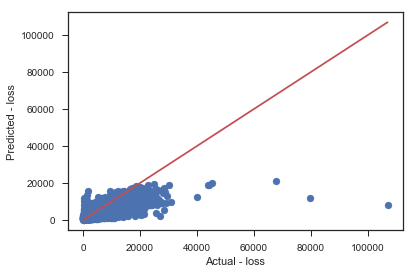

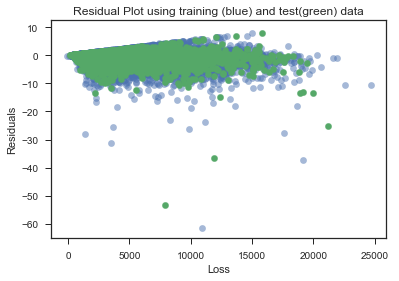

In [24]:
X_train, X_test, y_train, y_test = data.get_split()
X_train = nmf.transform(X_train)
X_test = nmf.transform(X_test)

y_test_predict = gbr.predict(X_test)
y_train_predict = gbr.predict(X_train)

# Plot of predicted values versus the true values
plt.figure()
plt.scatter(y_test, y_test_predict)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r')
plt.ylabel('Predicted - loss')
plt.xlabel('Actual - loss')

# Plot of residuals
plt.figure()
plt.scatter(y_train_predict, stats.zscore(y_train_predict - y_train),
                                                    c='b', s=40, alpha=0.5)
plt.scatter(y_test_predict, stats.zscore(y_test_predict - y_test),
                                                    c='g', s=40)
plt.hlines(y=0, xmin=0, xmax=20)
plt.title('Residual Plot using training (blue) and test(green) data')
plt.ylabel('Residuals')
plt.xlabel('Loss')
plt.show()

In [20]:
data = Data("train.csv")
X_train, y_train = data.df_X, data.df_y
X_test = data.read_test_data("test.csv")
X_test = data.df_X_test

nmf = NMF(n_components=90)
X_train_trans = nmf.fit_transform(X_train)
X_test_trans = nmf.transform(X_test)

y_train_trans = np.log1p(y_train)

gbr = GradientBoostingRegressor(loss='huber', alpha=0.5,
                                n_estimators=600, max_depth=6,
                                learning_rate=0.1, min_samples_leaf=10,
                                min_samples_split=10)

t_0 = time.time()
gbr.fit(X_train_trans, y_train_trans)

t_1 = time.time()
print(f'Time elapsed for model construction {t_1 - t_0:.3f} sec')

y_test_predict = np.expm1(gbr.predict(X_test_trans))

X_test['loss'] = y_test_predict
X_test['loss'].to_csv("GBR-NMF-log-submission.csv", header=True)

Time elapsed for model construction 2696.148 sec


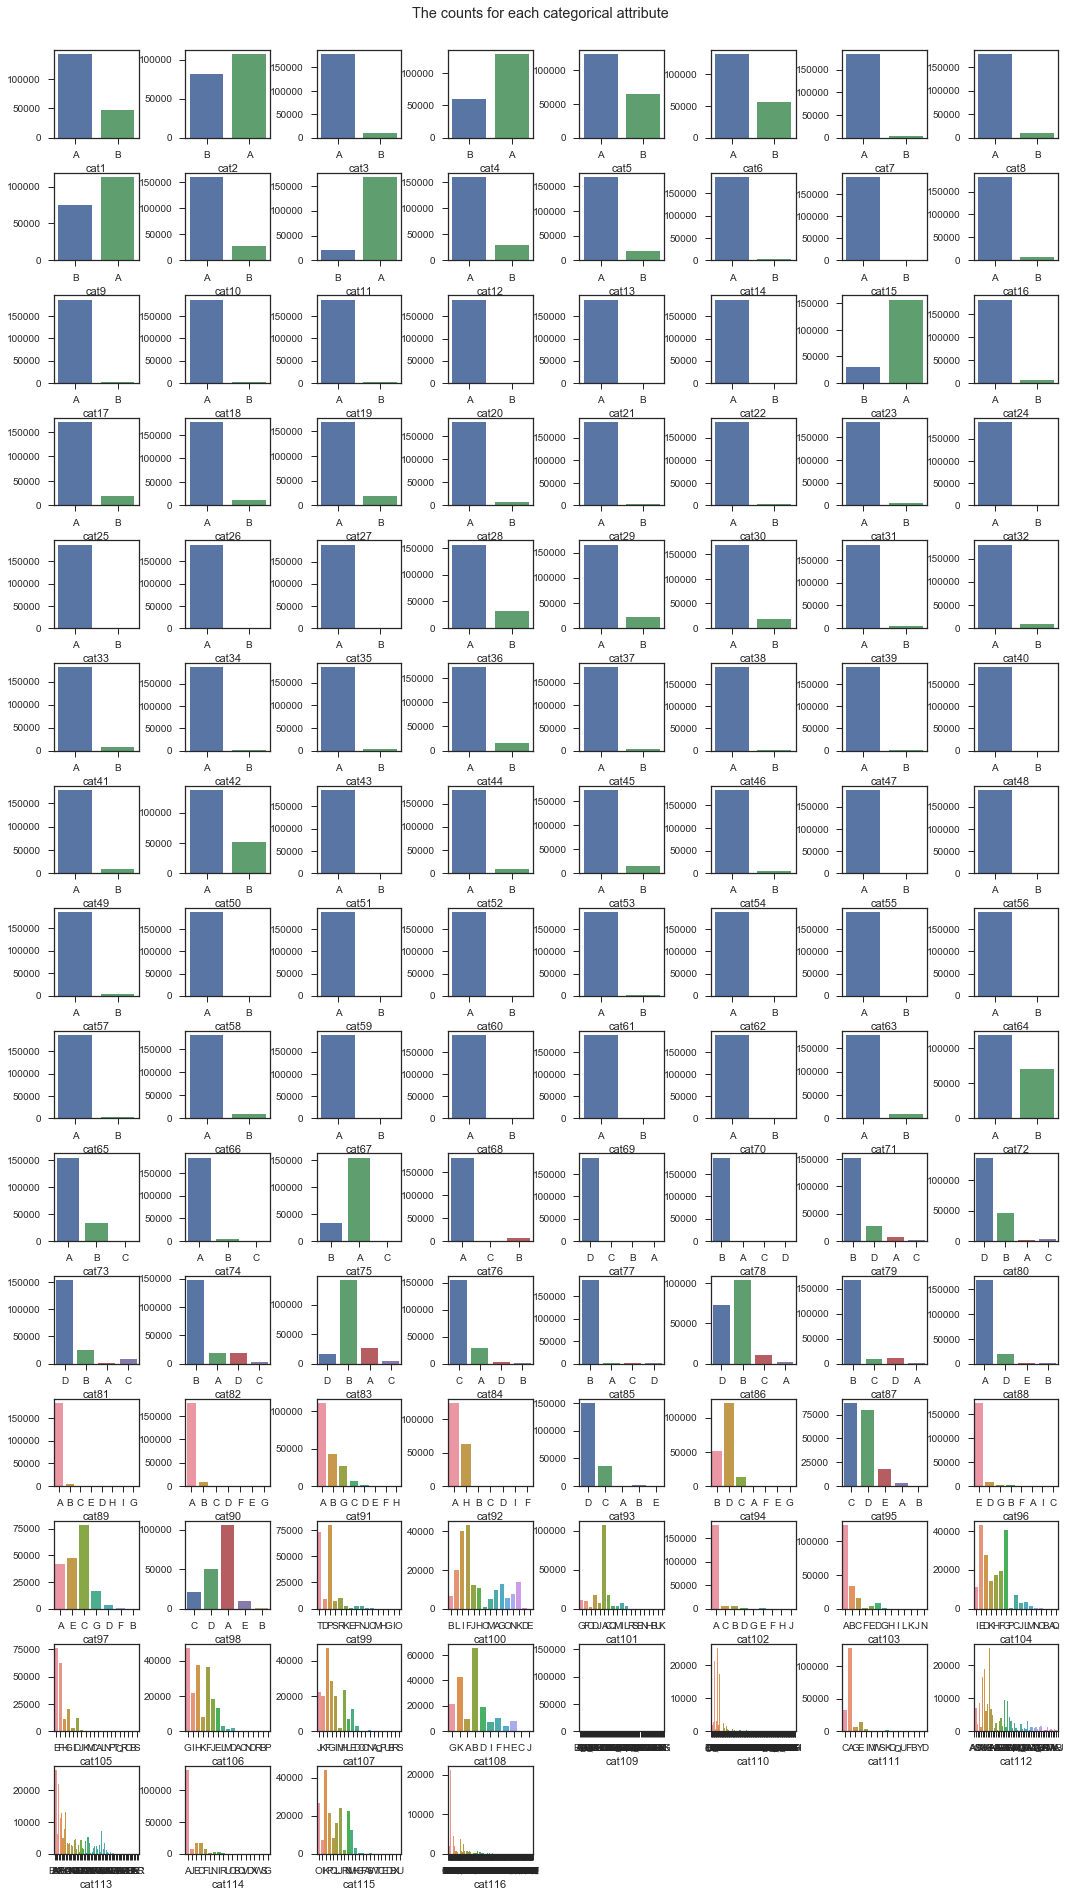

In [6]:
X_train = pd.read_csv("train.csv", index_col='id')

# Count the number of items for each categorical attribute
cat_index = [x for x in X_train.columns if x.startswith('cat')]

n = 8
r = len(cat_index)//n + 1
plt.figure(figsize=(18, 30))
for i in range(r):
    for j in range(n if i != r-1
                     else ((len(cat_index)%n))
                  ):
        if (i*n + j + 1) > len(cat_index):
            break
        plot = plt.subplot(r, n, (i*n + j + 1))
        ax = sns.countplot(x=cat_index[i*n + j], data=X_train)
        plt.subplots_adjust(wspace=0.55, hspace=0.4, top=0.96)
        ax.set_ylabel('')
plt.suptitle('The counts for each categorical attribute')
plt.show()

In [8]:
cat_index = [x for x in X_train.columns if x.startswith('cat')]

def letter_to_numb(series):
    ret = []
    for c in series:
        if len(c) == 1:
            ret.append(ord(c.lower()) - 96)
        else:
            ret.append('')
            for s in c:
                ret[-1] += str(ord(s.lower()) - 96)
            ret[-1] = int(ret[-1])
    return ret
            
    
integer_categories = X_train[cat_index].apply(letter_to_numb)

corr = integer_categories.corr(method='kendall') # spearman and kendall-tau mostly agree

corr_matrix = corr.abs()
sorted_corr = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))
print('The most correlated categorical attributes are:')
sorted_corr[sorted_corr > 0.87]

The most correlated categorical attributes are:


cat7   cat89    0.999
cat3   cat90    0.998
cat8   cat102   0.991
cat4   cat111   0.934
cat2   cat9     0.932
cat6   cat50    0.926
       cat114   0.925
cat5   cat103   0.925
cat86  cat99    0.888
dtype: float64

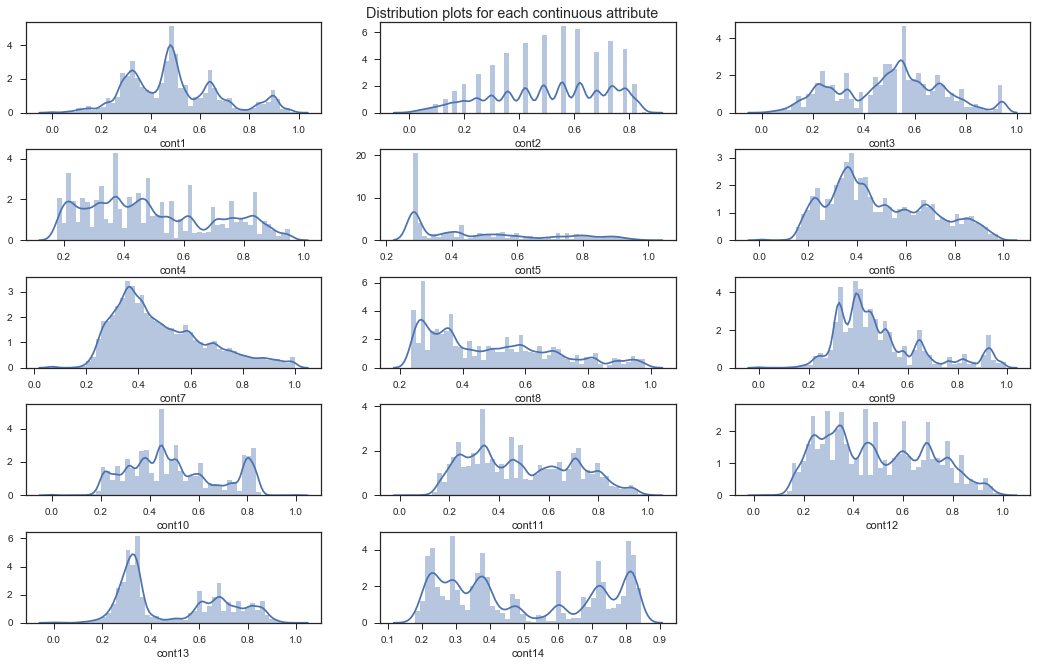

In [9]:
cont_index = lambda : [x for x in X_train.columns if x.startswith('cont')]
plt.figure(figsize=(18, 10))

n = len(cont_index())
for i, col in enumerate(cont_index()):
    plot = plt.subplot(n//3+1, 3, i + 1)
    sns.distplot(X_train[col])
    plot.set_xlabel(f'{col}')
    plt.subplots_adjust(hspace=0.4, top=0.96)
plt.suptitle('Distribution plots for each continuous attribute')
plt.show()